In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, requests
from datetime import datetime as dt
import random as rd
from geopy.geocoders import Nominatim
import re
import itertools

In [2]:
pd.set_option('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None)
pd.options.mode.chained_assignment = None

In [3]:
def pretty_json(j):
    print(json.dumps(j, indent=2))

In [4]:
# http://dev.opentripplanner.org/apidoc/2.0.0/resource_PlannerResource.html
# http://docs.opentripplanner.org/en/latest/Configuration/#routing-modes
    
def OTP_API_get_plan(orig, dest, time=dt.now().strftime("%I:%M%p").lower(), date=dt.now().strftime("%m-%d-%Y"), mode='WALK,TRANSIT', numItineraries=1, maxWalkDistance=1000):

    query = f'fromPlace={orig[0]},{orig[1]}&toPlace={dest[0]},{dest[1]}&time={time}&date={date}&mode={mode}&numItineraries={numItineraries}&maxWalkDistance={maxWalkDistance}'
    url = f'http://127.0.0.1:8080/otp/routers/default/plan?{query}'
    try:
        return json.loads(requests.get(url).text)
    except IOError as err:
        errno, strerror = err.args
        print(f'I/O error({errno}): {strerror}')
    except ValueError:
        print('No JSON object could be decoded')
    except:
        print(f'Unexpected error: {sys.exc_info()[0]}')
    
    return None

In [5]:
%%script false --no-raise-error

# TEST : saclay - orly
plan = OTP_API_get_plan((48.86697, 2.37167), (48.83489, 2.28310))
pretty_json(plan)

In [6]:
# Bounding box GPE : 2.070163,48.707927,2.595584,49.027041

def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

def get_rand_coords():
    lat = truncate(rd.uniform(48.707927, 49.027041), decimals=6)
    lon = truncate(rd.uniform(2.070163, 2.595584), decimals=6)
    return (lat, lon)

In [7]:
# https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula"

def distance(lat1, lon1, lat2, lon2):
    p = np.pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 12742 * np.arcsin(np.sqrt(a))

In [8]:
# https://pypi.org/project/geopy/
# pip install geopy
# conda install -c conda-forge geopy
# https://www.data.gouv.fr/en/datasets/base-officielle-des-codes-postaux/

df_zipcodes = pd.read_csv(f'./data/laposte_hexasmal.csv', delimiter=';')

def get_adress(x, y):
    return Nominatim(user_agent="my-app").reverse(f"{x} {y}").address

def get_zipcode(adress):
    zipcode = re.findall(r"\b\d{5}\b", adress)
    return int(zipcode[0]) if len(zipcode) > 0 else 0

def get_commune(zipcode):
    return next(iter(df_zipcodes.loc[df_zipcodes["Code_postal"] == zipcode, "Nom_commune"].values), "")

def get_departement(zipcode):
    return {
        "75": "PARIS",
        "77": "SEINE-ET-MARNE",
        "78": "YVELINES",
        "91": "ESSONE",
        "92": "HAUTS-DE-SEINE",
        "93": "SEINE-SAINT-DENIS",
        "94": "VAL-DE-MARNE",
        "95": "VAL-D'OISE"
    }[str(zipcode)[:2]]

def get_location(lat, lon):
    zipcode = get_zipcode(get_adress(lat, lon))
    return {
        "lat": lat,
        "lon": lon,
        "zipcode": zipcode,
        "commune": (get_commune(zipcode) if zipcode > 0 else ""),
        "departement": (get_departement(zipcode) if zipcode > 0 else "")
    }

In [9]:
def add_itinerary(orig, dest, mode, df_itineraries_):
    plan = OTP_API_get_plan(orig, dest, mode=mode, maxWalkDistance=('' if mode == 'CAR' else 1000))
    itinerary = next(iter(plan["plan"]["itineraries"]), None)
    coeff = 1.7 if mode == 'CAR' else 1.0
    return pd.concat([
        df_itineraries_,
        pd.DataFrame({
            "origin": [json.dumps(get_location(orig[0], orig[1]))],
            "destination": [json.dumps(get_location(dest[0], dest[1]))],
            "distance": [distance(dest[0], dest[1], orig[0], orig[1])],
            "mode": mode,
            "duration": [float(itinerary["duration"] if itinerary else 0)*coeff],
            "walktime": [float(itinerary["walkTime"] if itinerary  and not mode == 'CAR' else 0)],
            "transfers": [float(itinerary["transfers"] if itinerary and not mode == 'CAR' else 0)],
            "route": [json.dumps(
                ([{"mode": legs["mode"], "route": legs["route"], "agencyName": legs["agencyName"]}
                  for legs in itinerary["legs"] if not legs["mode"] == "WALK"] 
                 if itinerary and not mode == 'CAR' else [])
            )]
        })
    ], axis=0, ignore_index=True)

In [10]:
def get_coords(n):
    return [(get_rand_coords(), get_rand_coords()) for _ in range(n)]

def get_itineraries(coords_):
    
    df_itineraries_ = pd.DataFrame({
        "origin": [],
        "destination": [],
        "distance": [],
        "mode": [],
        "duration": [],
        "walktime": [],
        "transfers": [],
        "route": []
    })
    
    for i, c in enumerate(coords_):
        print(f"# {i+1} : lat={c[0]}, lon={c[1]}")
        df_itineraries_ = add_itinerary(c[0], c[1], 'WALK,TRANSIT', df_itineraries_)
        df_itineraries_ = add_itinerary(c[0], c[1], 'CAR', df_itineraries_)
        
    return df_itineraries_

In [11]:
def write_csv(df, name):
    df.loc[
        (df["origin"].map(lambda o: json.loads(o)["zipcode"] > 0)) &
        (df["destination"].map(lambda d: json.loads(d)["zipcode"] > 0)) &
        (df["duration"] > 0) & 
        (df["duration"] < 20000) & 
        (df["distance"] > 0)
    ].reset_index(drop=True). \
    to_csv(f'./data/{name}.csv', sep = ';')
    
def read_csv(name):
    df = pd.read_csv(f'./data/{name}.csv', delimiter=';', index_col=0)
    for column in ["origin", "destination", "route"]:
        df[column] = df[column].map(lambda r: json.loads(r))
    return df

In [12]:
def parse_point(point):
    point = point.replace('POINT (', '').replace(')', '').split(" ")
    return (truncate(float(point[1]), decimals=6), truncate(float(point[0]), decimals=6))

def get_coords_demand(n):
    df_demand = pd.read_excel('data/demand.xlsx', sheet_name='Sheet1', index_col=0)

    for points in ["Origin", "Destination"]:
        df_demand[points] = df_demand[points].map(lambda p: parse_point(p))
        df_demand = df_demand.loc[df_demand[points].map(lambda p: (48.707927 <= p[0] <= 49.027041) and (2.070163 <= p[1] <= 2.595584))]
    
    return df_demand.sample(n=n)[["Origin", "Destination"]].reset_index(drop=True).values.tolist()

In [13]:
%%script false --no-raise-error
# coords = get_coords(1000)
coords = get_coords_demand(2266)
len(coords)

In [14]:
%%script false --no-raise-error
write_csv(get_itineraries(coords), "idf")
# write_csv(get_itineraries(coords), "idf_demand")

In [15]:
%%script false --no-raise-error
write_csv(get_itineraries(coords), "gpe-idf")
# write_csv(get_itineraries(coords), "gpe-idf_demand")

In [16]:
df_itineraries_idf = read_csv("idf")
# df_itineraries_idf = read_csv("idf_demand")
df_itineraries_idf.head(10)

,origin,destination,distance,mode,duration,walktime,transfers,route
0,"{'lat': 48.912484, 'lon': 2.384493, 'zipcode': 93300, 'commune': 'AUBERVILLIERS', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.932453, 'lon': 2.581481, 'zipcode': 93410, 'commune': 'VAUJOURS', 'departement': 'SEINE-SAINT-DENIS'}",14.562987,"WALK,TRANSIT",3627.0,1730.0,1.0,"[{'mode': 'RAIL', 'route': 'B', 'agencyName': 'RER'}, {'mode': 'BUS', 'route': '643', 'agencyName': 'Seine-Saint-Denis'}]"
1,"{'lat': 48.912484, 'lon': 2.384493, 'zipcode': 93300, 'commune': 'AUBERVILLIERS', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.932453, 'lon': 2.581481, 'zipcode': 93410, 'commune': 'VAUJOURS', 'departement': 'SEINE-SAINT-DENIS'}",14.562987,CAR,3022.6,0.0,0.0,[]
2,"{'lat': 48.874921, 'lon': 2.485994, 'zipcode': 93110, 'commune': 'ROSNY SOUS BOIS', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.83625, 'lon': 2.56459, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}",7.180193,"WALK,TRANSIT",2409.0,1634.0,1.0,"[{'mode': 'RAIL', 'route': 'E', 'agencyName': 'RER'}, {'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}]"
3,"{'lat': 48.985464, 'lon': 2.350471, 'zipcode': 95410, 'commune': 'GROSLAY', 'departement': 'VAL-D'OISE'}","{'lat': 48.909519, 'lon': 2.333484, 'zipcode': 93400, 'commune': 'ST OUEN SUR SEINE', 'departement': 'SEINE-SAINT-DENIS'}",8.535327,"WALK,TRANSIT",2360.0,809.0,1.0,"[{'mode': 'RAIL', 'route': 'H', 'agencyName': 'TRAIN'}, {'mode': 'BUS', 'route': '274', 'agencyName': 'RATP'}]"
4,"{'lat': 48.985464, 'lon': 2.350471, 'zipcode': 95410, 'commune': 'GROSLAY', 'departement': 'VAL-D'OISE'}","{'lat': 48.909519, 'lon': 2.333484, 'zipcode': 93400, 'commune': 'ST OUEN SUR SEINE', 'departement': 'SEINE-SAINT-DENIS'}",8.535327,CAR,3150.1,0.0,0.0,[]
5,"{'lat': 48.83625, 'lon': 2.56459, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.828406, 'lon': 2.362248, 'zipcode': 75013, 'commune': 'PARIS 13', 'departement': 'PARIS'}",14.836222,"WALK,TRANSIT",3248.0,1646.0,1.0,"[{'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}, {'mode': 'SUBWAY', 'route': '14', 'agencyName': 'METRO'}]"
6,"{'lat': 48.83625, 'lon': 2.56459, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.828406, 'lon': 2.362248, 'zipcode': 75013, 'commune': 'PARIS 13', 'departement': 'PARIS'}",14.836222,CAR,2475.2,0.0,0.0,[]
7,"{'lat': 48.785817, 'lon': 2.539501, 'zipcode': 94490, 'commune': 'ORMESSON SUR MARNE', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.872719, 'lon': 2.312554, 'zipcode': 75008, 'commune': 'PARIS 08', 'departement': 'PARIS'}",19.218519,"WALK,TRANSIT",4524.0,902.0,2.0,"[{'mode': 'BUS', 'route': '308', 'agencyName': 'RATP'}, {'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}, {'mode': 'SUBWAY', 'route': '9', 'agencyName': 'METRO'}]"
8,"{'lat': 48.785817, 'lon': 2.539501, 'zipcode': 94490, 'commune': 'ORMESSON SUR MARNE', 'departement': 'VAL-DE-MARNE'}","{'lat': 48.872719, 'lon': 2.312554, 'zipcode': 75008, 'commune': 'PARIS 08', 'departement': 'PARIS'}",19.218519,CAR,5737.5,0.0,0.0,[]
9,"{'lat': 48.719934, 'lon': 2.463089, 'zipcode': 91560, 'commune': 'CROSNE', 'departement': 'ESSONE'}","{'lat': 48.847569, 'lon': 2.437668, 'zipcode': 94300, 'commune': 'VINCENNES', 'departement': 'VAL-DE-MARNE'}",14.314054,"WALK,TRANSIT",3702.0,1291.0,2.0,"[{'mode': 'BUS', 'route': 'Inter-Vals', 'agencyName': 'Seine Sénart Bus'}, {'mode': 'RAIL', 'route': 'D', 'agencyName': 'RER'}, {'mode': 'SUBWAY', 'route': '1', 'agencyName': 'METRO'}]"


In [17]:
df_itineraries_gpe_idf = read_csv("gpe-idf")
# df_itineraries_gpe_idf = read_csv("gpe-idf_demand")
df_itineraries_gpe_idf.head(10)

,origin,destination,distance,mode,duration,walktime,transfers,route
0,"{'lat': 48.926857, 'lon': 2.122464, 'zipcode': 78600, 'commune': 'MAISONS LAFFITTE', 'departement': 'YVELINES'}","{'lat': 48.868275, 'lon': 2.342896, 'zipcode': 75002, 'commune': 'PARIS 02', 'departement': 'PARIS'}",17.380510,"WALK,TRANSIT",3456.0,990.0,1.0,"[{'mode': 'BUS', 'route': '02', 'agencyName': 'Transdev Ile-de-France Conflans'}, {'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}]"
1,"{'lat': 48.926857, 'lon': 2.122464, 'zipcode': 78600, 'commune': 'MAISONS LAFFITTE', 'departement': 'YVELINES'}","{'lat': 48.868275, 'lon': 2.342896, 'zipcode': 75002, 'commune': 'PARIS 02', 'departement': 'PARIS'}",17.380510,CAR,5907.5,0.0,0.0,[]
2,"{'lat': 48.912484, 'lon': 2.384493, 'zipcode': 93300, 'commune': 'AUBERVILLIERS', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.932453, 'lon': 2.581481, 'zipcode': 93410, 'commune': 'VAUJOURS', 'departement': 'SEINE-SAINT-DENIS'}",14.562987,"WALK,TRANSIT",3458.0,1137.0,2.0,"[{'mode': 'SUBWAY', 'route': '15B', 'agencyName': 'METRO'}, {'mode': 'RAIL', 'route': 'B', 'agencyName': 'RER'}, {'mode': 'BUS', 'route': '643', 'agencyName': 'Seine-Saint-Denis'}]"
3,"{'lat': 48.912484, 'lon': 2.384493, 'zipcode': 93300, 'commune': 'AUBERVILLIERS', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.932453, 'lon': 2.581481, 'zipcode': 93410, 'commune': 'VAUJOURS', 'departement': 'SEINE-SAINT-DENIS'}",14.562987,CAR,3022.6,0.0,0.0,[]
4,"{'lat': 48.874921, 'lon': 2.485994, 'zipcode': 93110, 'commune': 'ROSNY SOUS BOIS', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.83625, 'lon': 2.56459, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}",7.180193,"WALK,TRANSIT",2409.0,1634.0,1.0,"[{'mode': 'RAIL', 'route': 'E', 'agencyName': 'RER'}, {'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}]"
5,"{'lat': 48.874921, 'lon': 2.485994, 'zipcode': 93110, 'commune': 'ROSNY SOUS BOIS', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.83625, 'lon': 2.56459, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}",7.180193,CAR,1932.9,0.0,0.0,[]
6,"{'lat': 48.985464, 'lon': 2.350471, 'zipcode': 95410, 'commune': 'GROSLAY', 'departement': 'VAL-D'OISE'}","{'lat': 48.909519, 'lon': 2.333484, 'zipcode': 93400, 'commune': 'ST OUEN SUR SEINE', 'departement': 'SEINE-SAINT-DENIS'}",8.535327,"WALK,TRANSIT",2360.0,809.0,1.0,"[{'mode': 'RAIL', 'route': 'H', 'agencyName': 'TRAIN'}, {'mode': 'BUS', 'route': '274', 'agencyName': 'RATP'}]"
7,"{'lat': 48.985464, 'lon': 2.350471, 'zipcode': 95410, 'commune': 'GROSLAY', 'departement': 'VAL-D'OISE'}","{'lat': 48.909519, 'lon': 2.333484, 'zipcode': 93400, 'commune': 'ST OUEN SUR SEINE', 'departement': 'SEINE-SAINT-DENIS'}",8.535327,CAR,3150.1,0.0,0.0,[]
8,"{'lat': 48.83625, 'lon': 2.56459, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.828406, 'lon': 2.362248, 'zipcode': 75013, 'commune': 'PARIS 13', 'departement': 'PARIS'}",14.836222,"WALK,TRANSIT",3225.0,1646.0,1.0,"[{'mode': 'RAIL', 'route': 'A', 'agencyName': 'RER'}, {'mode': 'SUBWAY', 'route': '14', 'agencyName': 'METRO'}]"
9,"{'lat': 48.83625, 'lon': 2.56459, 'zipcode': 93160, 'commune': 'NOISY LE GRAND', 'departement': 'SEINE-SAINT-DENIS'}","{'lat': 48.828406, 'lon': 2.362248, 'zipcode': 75013, 'commune': 'PARIS 13', 'departement': 'PARIS'}",14.836222,CAR,2475.2,0.0,0.0,[]


In [18]:
def averages(df_itineraries_, idx):
    df_itineraries_ = df_itineraries_.loc[df_itineraries_["mode"] == "WALK,TRANSIT"]
    return pd.DataFrame({
        "Trips found" : [len(df_itineraries_)],
        "Duration" : [round(df_itineraries_["duration"].mean(), 2)],
        "Transfers" : [round(df_itineraries_["transfers"].mean(), 2)],
        "Distance" : [round(df_itineraries_["distance"].mean(), 2)],
        "Walktime" : [round(df_itineraries_["walktime"].mean(), 2)]
    }, index=[idx])

In [19]:
def plot_metrics_by_epoch(df_itineraries_idf_, df_itineraries_gpe_idf_, area):
    df_averages = pd.concat([
        averages(df_itineraries_idf_, f"{area} IDF now"),
        averages(df_itineraries_gpe_idf_, f"{area} IDF GPE")
    ])
    df_averages.index.names = ["epoch"]
    
    display(df_averages)
    
    columns = df_averages.columns.values.tolist()
    
    fig, axes = plt.subplots(5, 1, figsize=(20, 10))
    fig.suptitle(f'{area} Transit metrics before/after', fontsize=24)
    for e, c in enumerate(columns):
        sns.barplot(ax=axes[e], x=c, y="epoch", data=df_averages.reset_index(), saturation=.5)
        axes[e].set_ylabel(c)
        axes[e].set_xlabel("")
    None

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
IDF now,2199,3875.62,1.73,12.68,1193.84
IDF GPE,2520,3728.09,1.72,13.22,1309.05


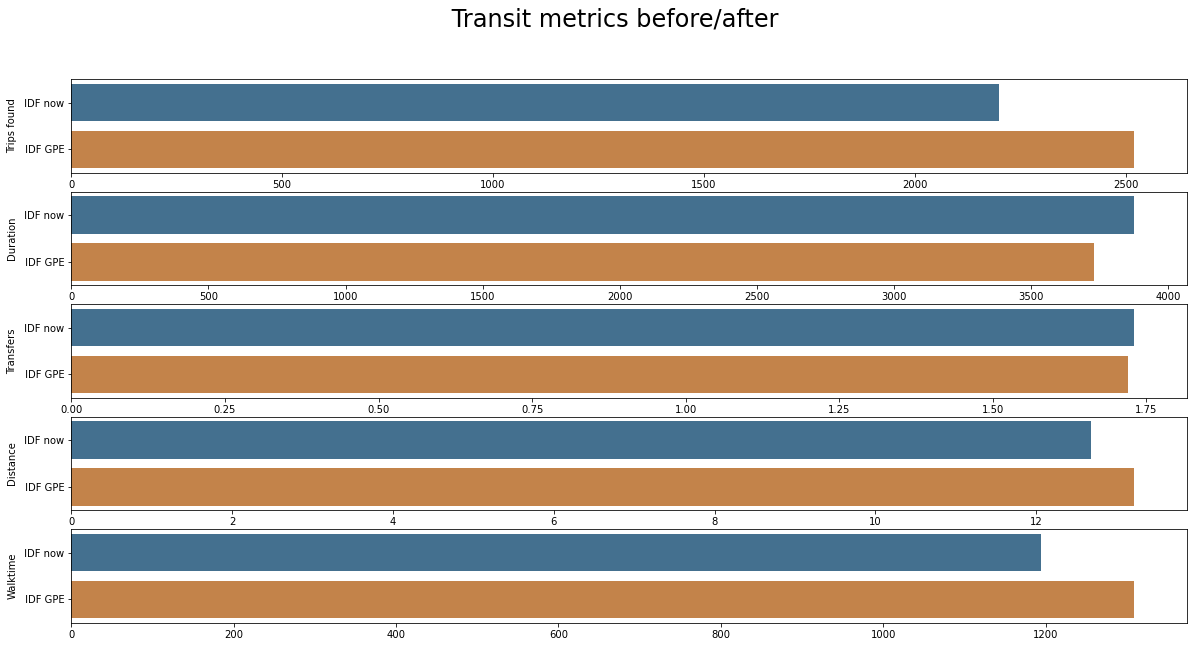

In [20]:
plot_metrics_by_epoch(df_itineraries_idf, df_itineraries_gpe_idf, "")

In [21]:
def plot_itineraries_hist_by_mode(df_itineraries_, title):
    plt.figure(figsize=(20, 10))
    sns.histplot(data=df_itineraries_, x="duration", hue="mode", kde=True, element="step")
    plt.title(f'{title}', fontsize=24)
    None

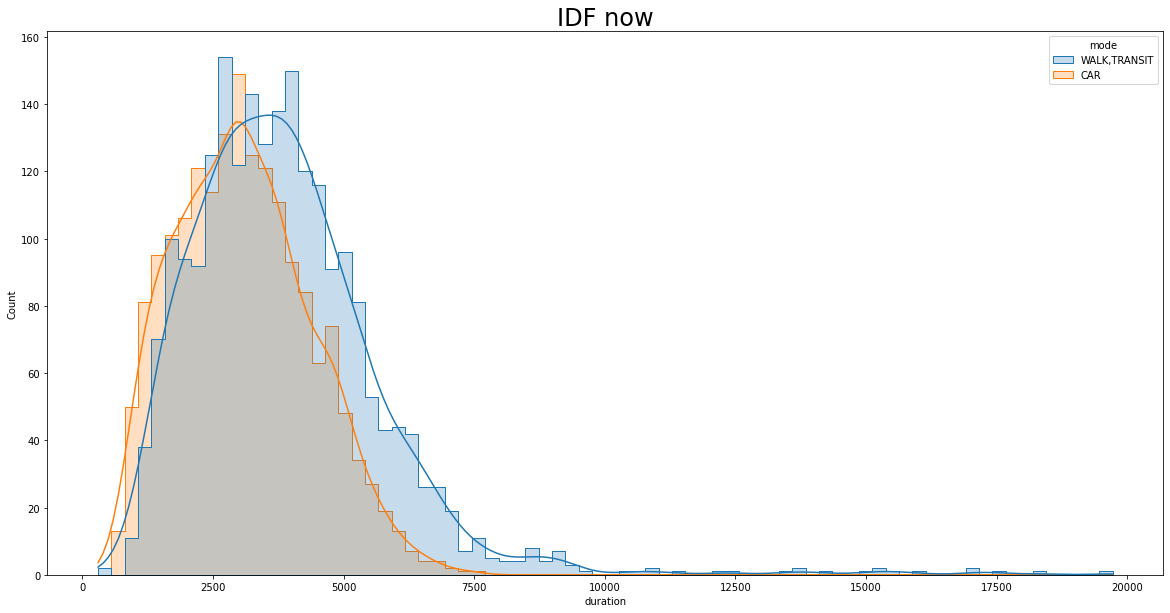

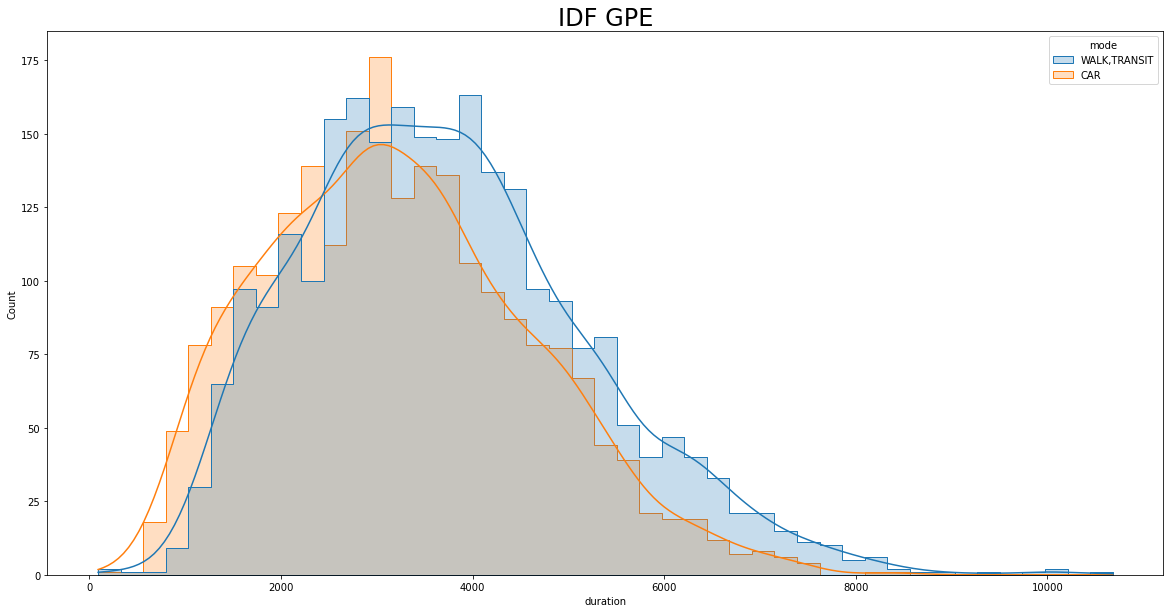

In [22]:
plot_itineraries_hist_by_mode(df_itineraries_idf, "IDF now")
plot_itineraries_hist_by_mode(df_itineraries_gpe_idf, "IDF GPE")

In [23]:
def get_modes(df_itineraries_):
    return pd.DataFrame([
        [
            sr["agencyName"] if sr["agencyName"] in ["TRAIN", "RER", "METRO", "TRAMWAY"] else sr["mode"],
            sr["route"]
        ] for sr in [
            subroute for route in [
                routes for routes in 
                df_itineraries_.loc[df_itineraries_["route"].map(lambda r: len(r)) > 0, ["route"]]["route"].values
            ] for subroute in route
        ]
    ], columns = ["mode", "route"]). \
    sort_values("mode", ignore_index=True)

In [24]:
df_modes_idf = get_modes(df_itineraries_idf)
df_modes_idf.head(10)

,mode,route
0,BUS,110
1,BUS,183
2,BUS,173
3,BUS,249
4,BUS,235
5,BUS,221
6,BUS,26
7,BUS,172
8,BUS,147
9,BUS,15


In [25]:
df_modes_gpe_idf = get_modes(df_itineraries_gpe_idf)
df_modes_gpe_idf.head(10)

,mode,route
0,BUS,02
1,BUS,23
2,BUS,394
3,BUS,Inter-Vals
4,BUS,460
5,BUS,262 Versailles - St-Rémy-lès-Chevreuse
6,BUS,301
7,BUS,9
8,BUS,42
9,BUS,33


In [26]:
print("IDF now:", list(df_modes_idf["mode"].unique()))
print("IDF GPE:", list(df_modes_gpe_idf["mode"].unique()))

IDF now: ['BUS', 'FUNICULAR', 'METRO', 'RER', 'TRAIN', 'TRAMWAY']
IDF GPE: ['BUS', 'FUNICULAR', 'METRO', 'RAIL', 'RER', 'TRAIN', 'TRAMWAY']


In [27]:
def percentage_by_column(column, df):
    return pd.merge(
        df.groupby(column)[column].count().reset_index(name='Percentage').set_index(column). \
        apply(lambda Percentage: 100 * Percentage / float(Percentage.sum())).round({'Percentage': 2}),
        df.groupby(column)[column].count().reset_index(name='Count').set_index(column),
        how="left",
        on=column
    ).sort_values(['Count'], ascending=False)

In [28]:
def display_percentage_by_column(title, column, df):      
    df = percentage_by_column(column, df)
    display(pd.concat([
        df,
        pd.DataFrame({"Percentage": 100.0, "Count": [df["Count"].sum()]}, index=["Total"])
    ]))
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))    
    fig.suptitle(f'{title}', fontsize=24)

    axes[0].set_title('Percentage')
    axes[0].pie(df["Percentage"], labels=df.index.values, autopct='%1.1f%%')

    axes[1].set_title('Count')
    sns.barplot(ax=axes[1], x=column, y="Count", data=df.reset_index(), saturation=.5)
    None

# IDF now

,Percentage,Count
BUS,44.81,2671
RER,27.36,1631
METRO,15.52,925
TRAIN,7.99,476
TRAMWAY,4.16,248
FUNICULAR,0.17,10
Total,100.00,5961


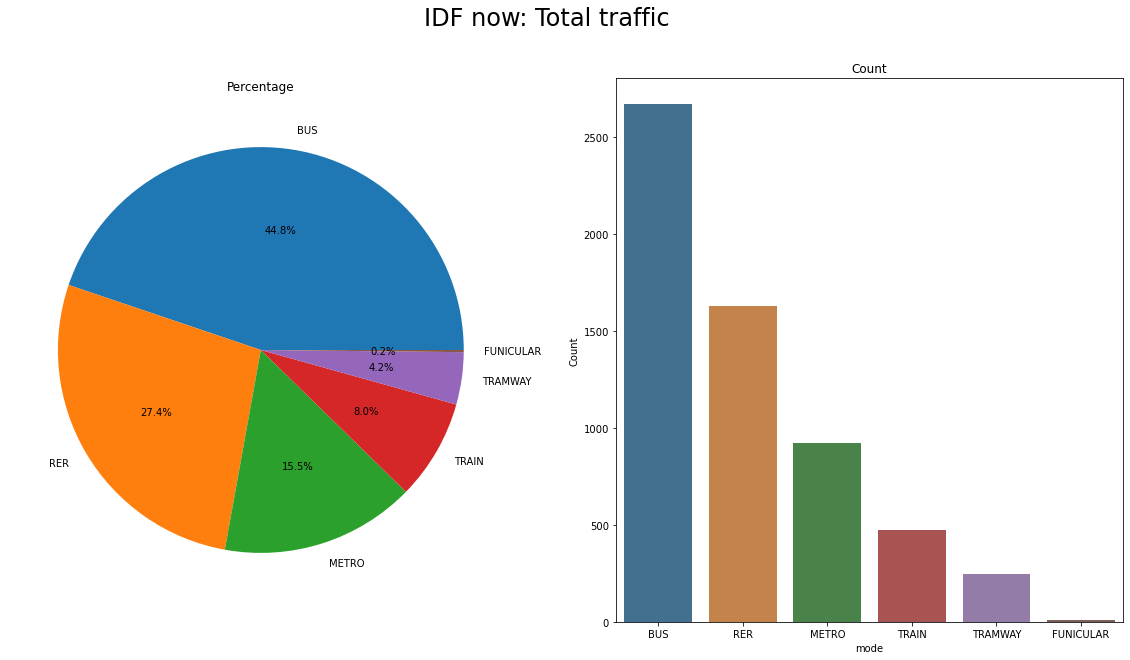

In [29]:
display_percentage_by_column("IDF now: Total traffic", "mode", df_modes_idf)

,Percentage,Count
9,13.95,129
13,12.86,119
14,12.11,112
4,10.70,99
5,10.05,93
7,8.43,78
8,7.68,71
1,6.49,60
3,5.62,52
2,4.22,39


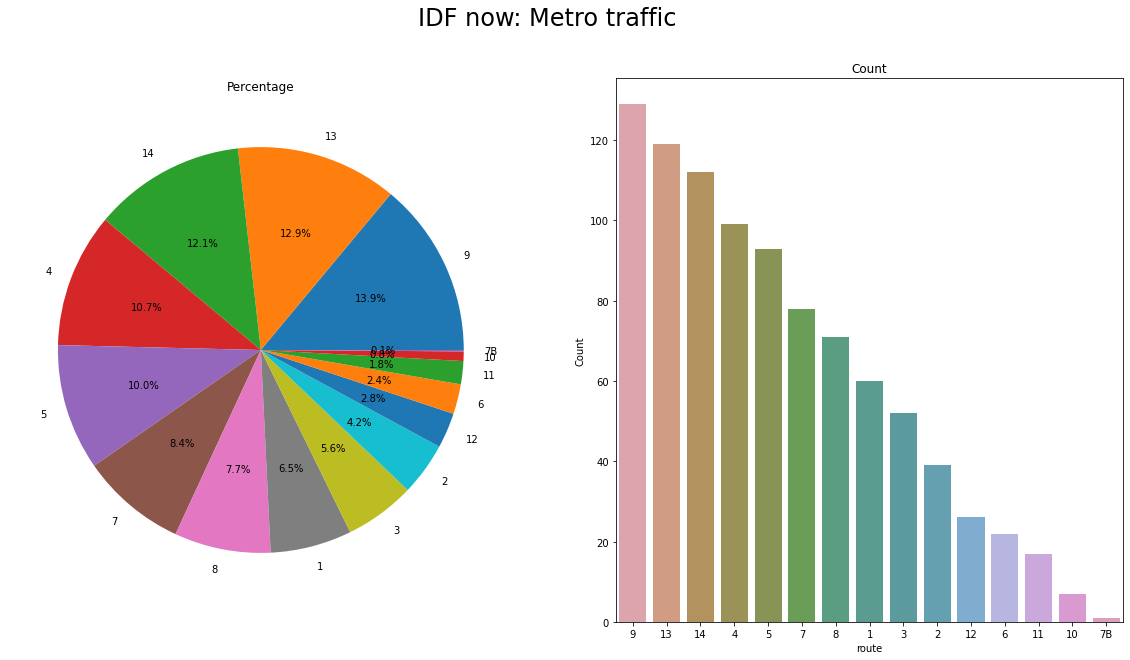

In [30]:
display_percentage_by_column("IDF now: Metro traffic", "route", df_modes_idf.loc[df_modes_idf["mode"] == "METRO"])

,Percentage,Count
A,33.60,548
B,28.63,467
C,14.78,241
D,14.78,241
E,8.22,134
Total,100.00,1631


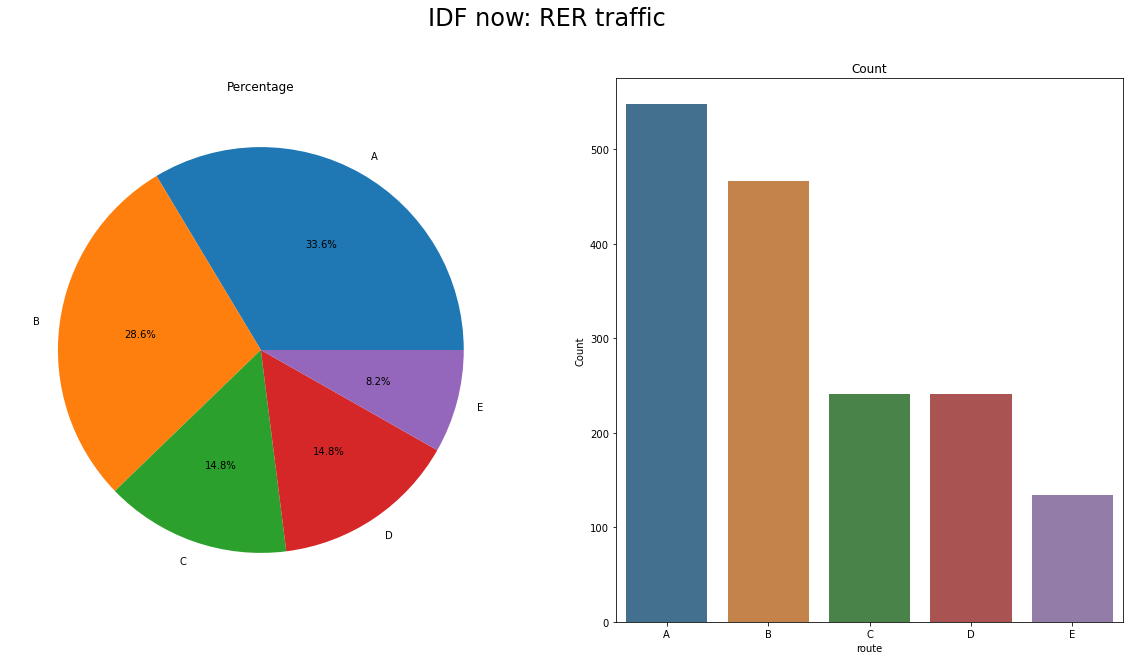

In [31]:
display_percentage_by_column("IDF now: RER traffic", "route", df_modes_idf.loc[df_modes_idf["mode"] == "RER"])

# IDF GPE

,Percentage,Count
BUS,39.87,2714
METRO,26.56,1808
RER,22.33,1520
TRAIN,7.43,506
TRAMWAY,3.26,222
RAIL,0.48,33
FUNICULAR,0.06,4
Total,100.00,6807


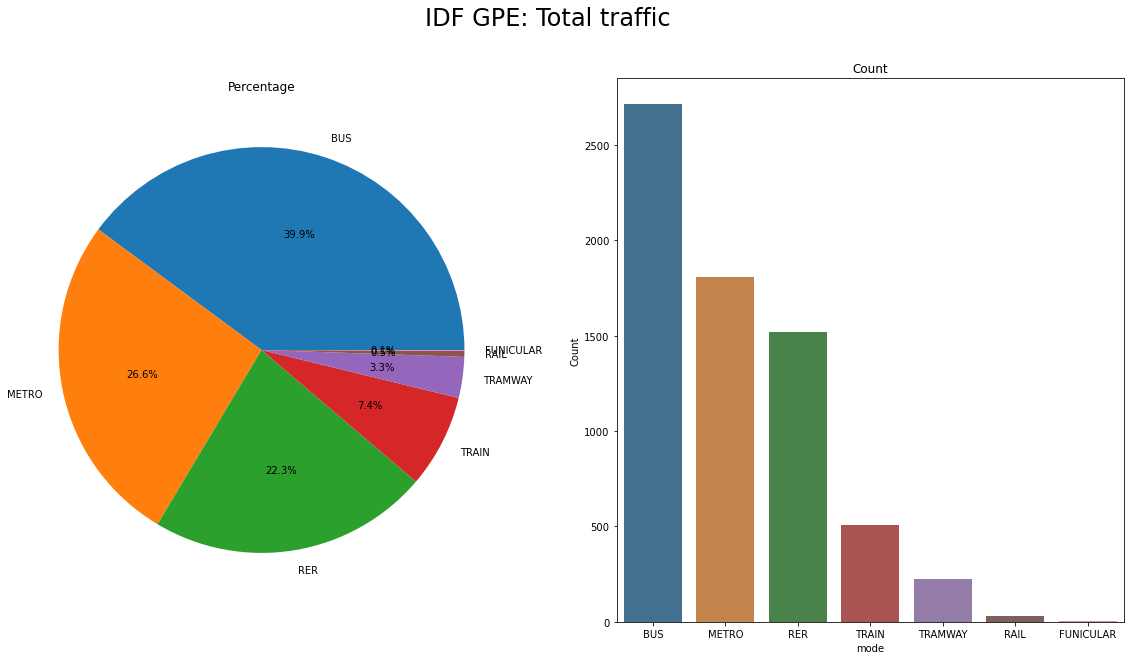

In [32]:
display_percentage_by_column("IDF GPE: Total traffic", "mode", df_modes_gpe_idf)

,Percentage,Count
15,26.77,484
14,13.38,242
15B,10.73,194
16,6.86,124
9,6.69,121
13,6.19,112
5,4.26,77
4,4.15,75
8,3.93,71
3,2.93,53


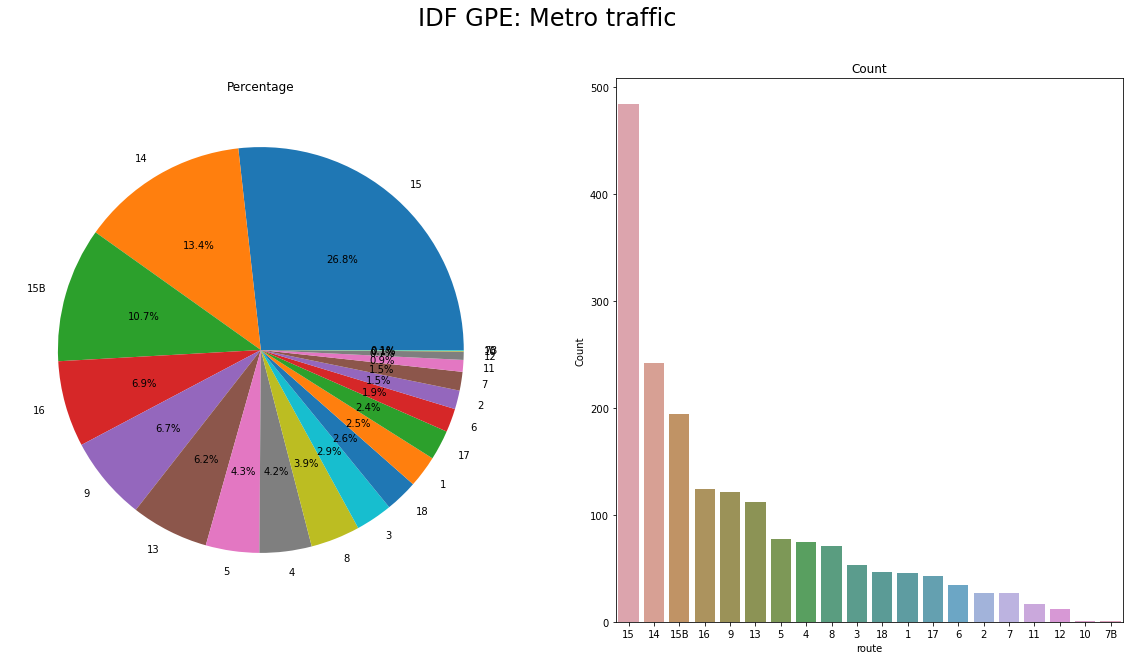

In [33]:
display_percentage_by_column("IDF GPE: Metro traffic", "route", df_modes_gpe_idf.loc[df_modes_gpe_idf["mode"] == "METRO"])

,Percentage,Count
A,36.97,562
B,23.75,361
C,19.54,297
D,13.62,207
E,6.12,93
Total,100.00,1520


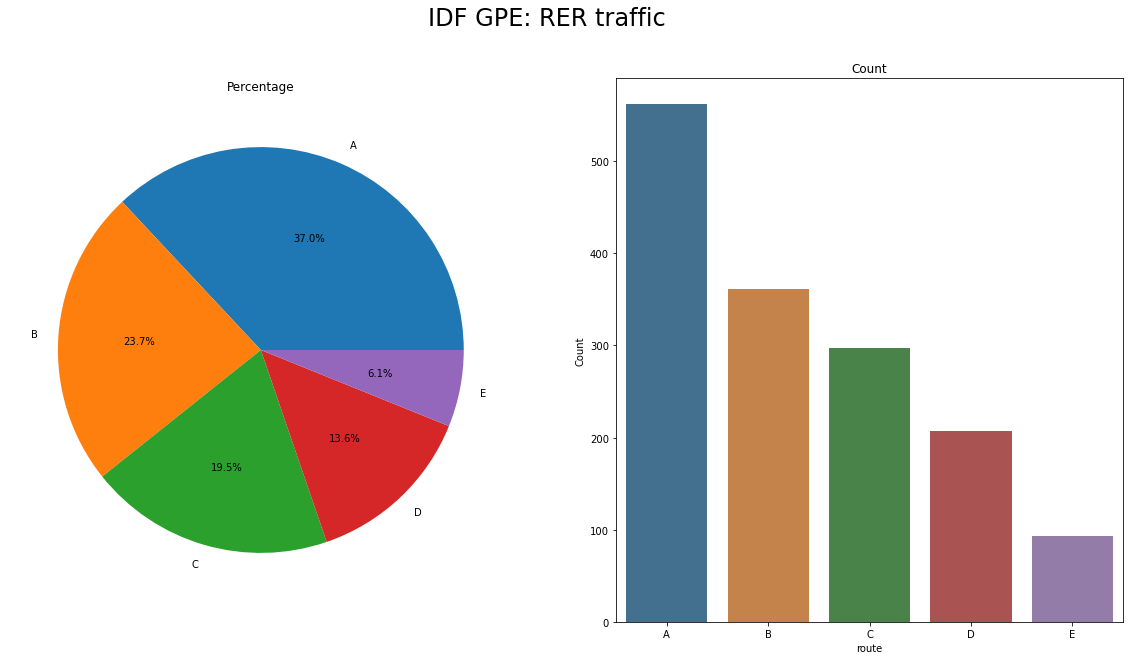

In [34]:
display_percentage_by_column("IDF GPE: RER traffic", "route", df_modes_gpe_idf.loc[df_modes_gpe_idf["mode"] == "RER"])

# Durations between Areas

In [35]:
def add_area(df_itineraries_):
    df_itineraries_["area"] = ""
    
    df_itineraries_.loc[(
        (df_itineraries_["origin"].map(lambda o: o["departement"] == "PARIS")) &
        (df_itineraries_["destination"].map(lambda d: d["departement"] == "PARIS"))
    ), "area"] = "PARIS,PARIS"
    
    df_itineraries_.loc[(
        (df_itineraries_["origin"].map(lambda o: not o["departement"] == "PARIS")) &
        (df_itineraries_["destination"].map(lambda d: not d["departement"] == "PARIS"))
    ), "area"] = "SUBURB,SUBURB"
    
    df_itineraries_.loc[(
        (
            (df_itineraries_["origin"].map(lambda o: not o["departement"] == "PARIS")) & 
            (df_itineraries_["destination"].map(lambda d: d["departement"] == "PARIS"))
        ) | (
            (df_itineraries_["origin"].map(lambda o: o["departement"] == "PARIS")) & 
            (df_itineraries_["destination"].map(lambda d: not d["departement"] == "PARIS"))
        )
    ), "area"] = "PARIS,SUBURB"
    
    return df_itineraries_
    
def plot_metrics_by_area(area):
    plot_metrics_by_epoch(
        df_itineraries_idf.loc[(df_itineraries_idf["area"] == area) & (df_itineraries_idf["mode"] == 'WALK,TRANSIT')],
        df_itineraries_gpe_idf.loc[(df_itineraries_gpe_idf["area"] == area) & (df_itineraries_gpe_idf["mode"] == 'WALK,TRANSIT')],
        area
    )

In [36]:
df_itineraries_idf = add_area(df_itineraries_idf)
df_itineraries_gpe_idf = add_area(df_itineraries_gpe_idf)

# PARIS - PARIS

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
"PARIS,PARIS IDF now",7,2284.00,1.14,5.25,917.14
"PARIS,PARIS IDF GPE",7,2261.43,1.14,5.25,900.71


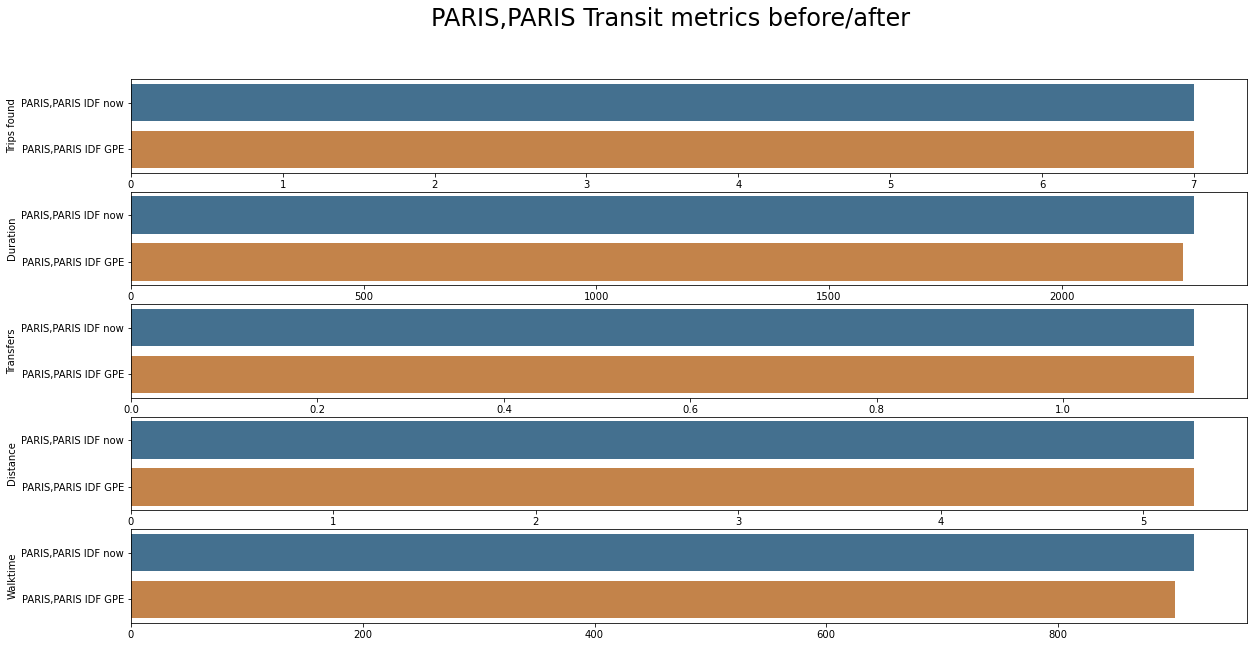

In [37]:
plot_metrics_by_area("PARIS,PARIS")

# PARIS - SUBURB

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
"PARIS,SUBURB IDF now",633,3414.41,1.68,12.31,1077.28
"PARIS,SUBURB IDF GPE",691,3371.44,1.68,12.76,1152.35


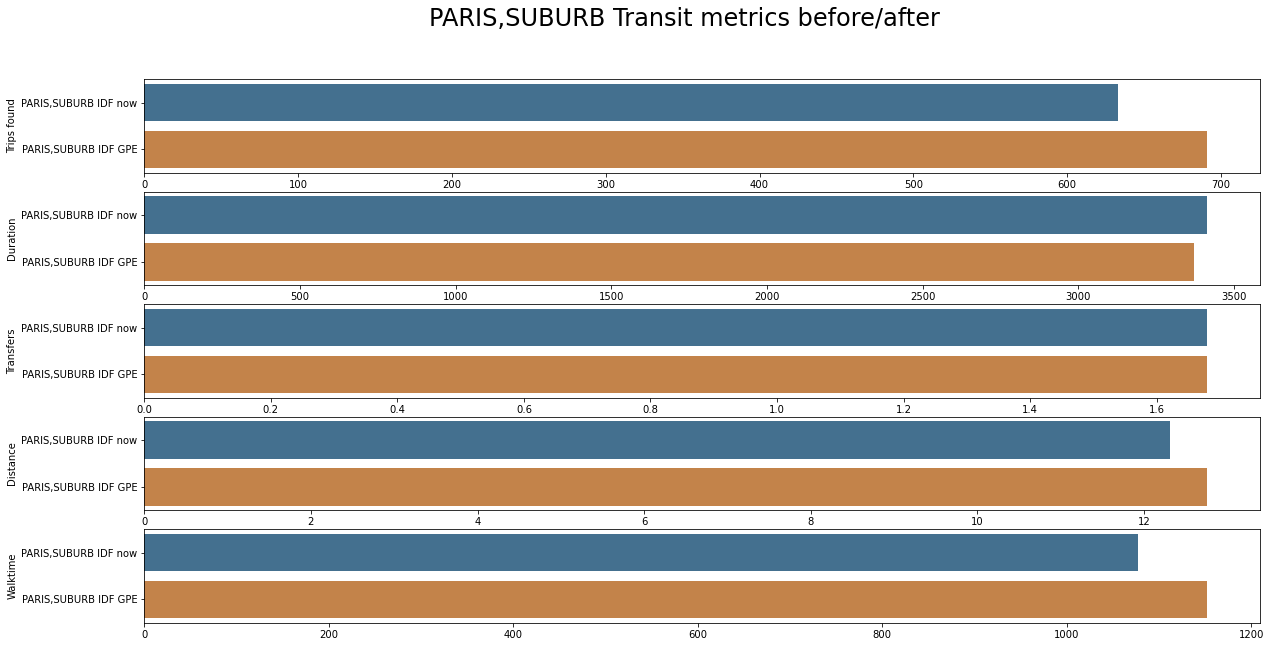

In [38]:
plot_metrics_by_area("PARIS,SUBURB")

# SUBURB - SUBURB

,Trips found,Duration,Transfers,Distance,Walktime
epoch,,,,,
"SUBURB,SUBURB IDF now",1559,4070.03,1.75,12.87,1242.41
"SUBURB,SUBURB IDF GPE",1822,3868.98,1.74,13.42,1370.05


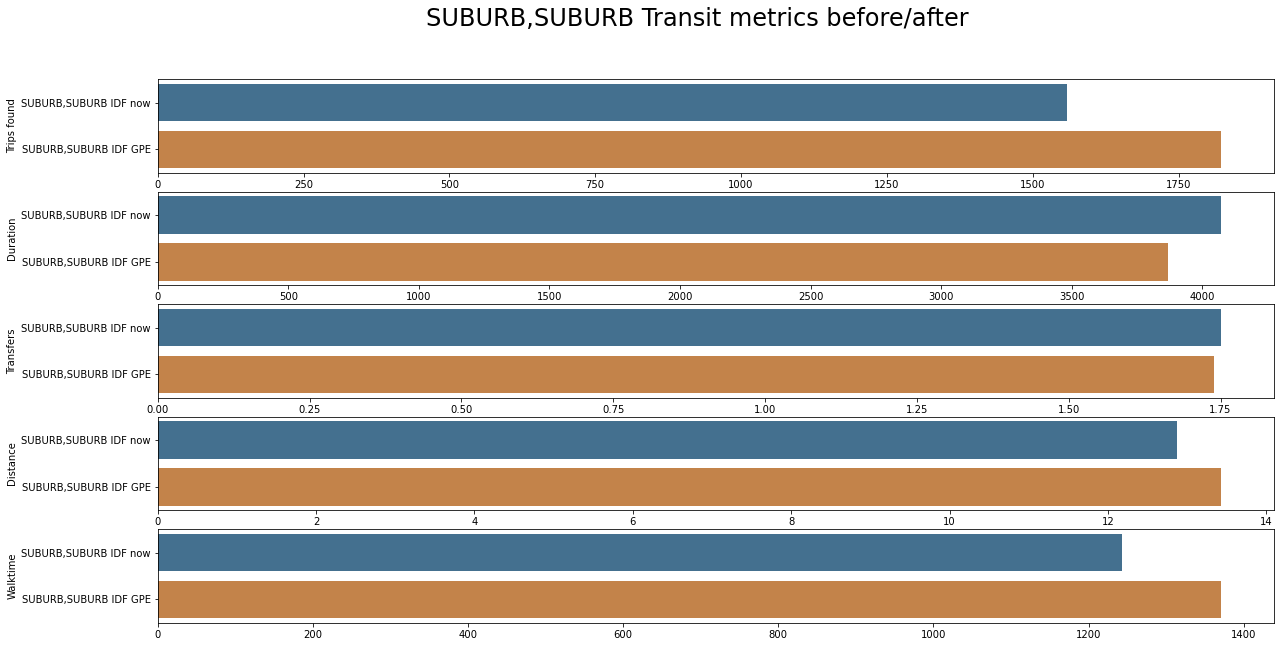

In [39]:
plot_metrics_by_area("SUBURB,SUBURB")

In [40]:
def add_area_departement(df_itineraries_):
    departements = [
        "PARIS",
        "SEINE-ET-MARNE",
        "YVELINES",
        "ESSONE",
        "HAUTS-DE-SEINE",
        "SEINE-SAINT-DENIS",
        "VAL-DE-MARNE",
        "VAL-D'OISE"
    ]

    combinations = list(itertools.combinations(departements, 2))
    for d in departements:
        combinations.append((d, d))
    
    df_itineraries_["area_departement"] = ""
    
    for c in combinations:
        df_itineraries_.loc[(
            (
                (df_itineraries_["origin"].map(lambda o: o["departement"] == c[0])) & 
                (df_itineraries_["destination"].map(lambda d: d["departement"] == c[1]))
            ) | (
                (df_itineraries_["origin"].map(lambda o: o["departement"] == c[1])) & 
                (df_itineraries_["destination"].map(lambda d: d["departement"] == c[0]))
            )
        ), "area_departement"] = f"{c[0]},{c[1]}"
    
    return df_itineraries_

In [41]:
df_itineraries_idf = add_area_departement(df_itineraries_idf)
df_itineraries_gpe_idf = add_area_departement(df_itineraries_gpe_idf)

In [42]:
def get_mean_duration_between_departements(df_itineraries_):
    return df_itineraries_[["duration", "area_departement"]].groupby("area_departement").mean().round(2) .sort_values("duration", ascending=False)

In [43]:
def plot_mean_duration_between_departements(df, title, y_):
    plt.figure(figsize=(20, 10))
    sns.barplot(x="area_departement", y=y_, data=df.reset_index(), saturation=.5)
    plt.xticks(rotation=90)
    plt.title(f'{title}', fontsize=24)
    None

In [44]:
df_duration = pd.concat([
    get_mean_duration_between_departements(df_itineraries_idf).rename(columns={'duration': 'duration_idf'}),
    get_mean_duration_between_departements(df_itineraries_gpe_idf).rename(columns={'duration': 'duration_gpe_idf'})
], axis=1)

df_duration["duration_improvement"] = - 100 * (df_duration["duration_gpe_idf"] - df_duration["duration_idf"]) / df_duration["duration_idf"]
df_duration = df_duration.sort_values("duration_improvement", ascending=False)
df_duration.index.names = ["area_departement"]
df_duration

,duration_idf,duration_gpe_idf,duration_improvement
area_departement,,,
"YVELINES,YVELINES",4225.63,2642.53,37.464236
"YVELINES,HAUTS-DE-SEINE",5100.80,3512.36,31.140997
"PARIS,YVELINES",6263.75,4359.29,30.404470
"YVELINES,VAL-D'OISE",6638.40,5181.08,21.952880
"YVELINES,VAL-DE-MARNE",6754.59,5430.35,19.605039
"YVELINES,SEINE-SAINT-DENIS",6378.55,5299.91,16.910426
"ESSONE,ESSONE",3134.88,2869.84,8.454550
"SEINE-ET-MARNE,YVELINES",7230.00,6715.01,7.122960
"HAUTS-DE-SEINE,HAUTS-DE-SEINE",2778.83,2582.45,7.067003


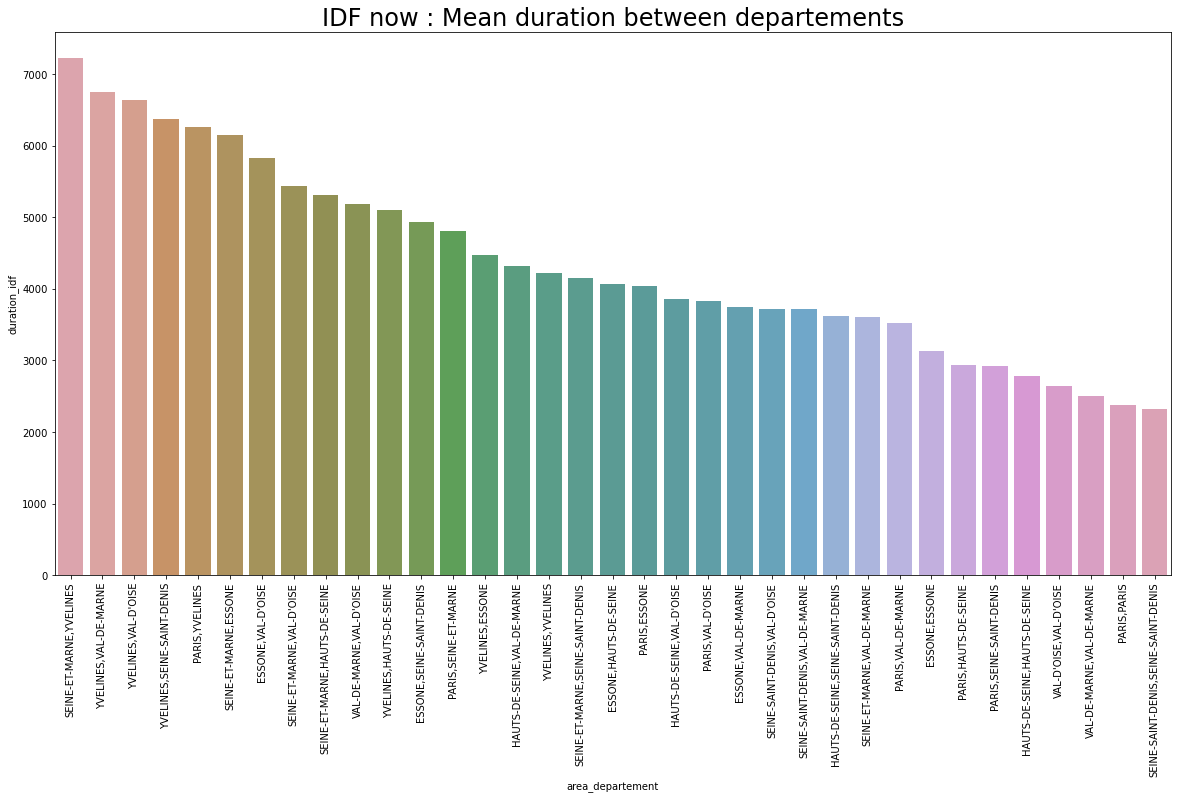

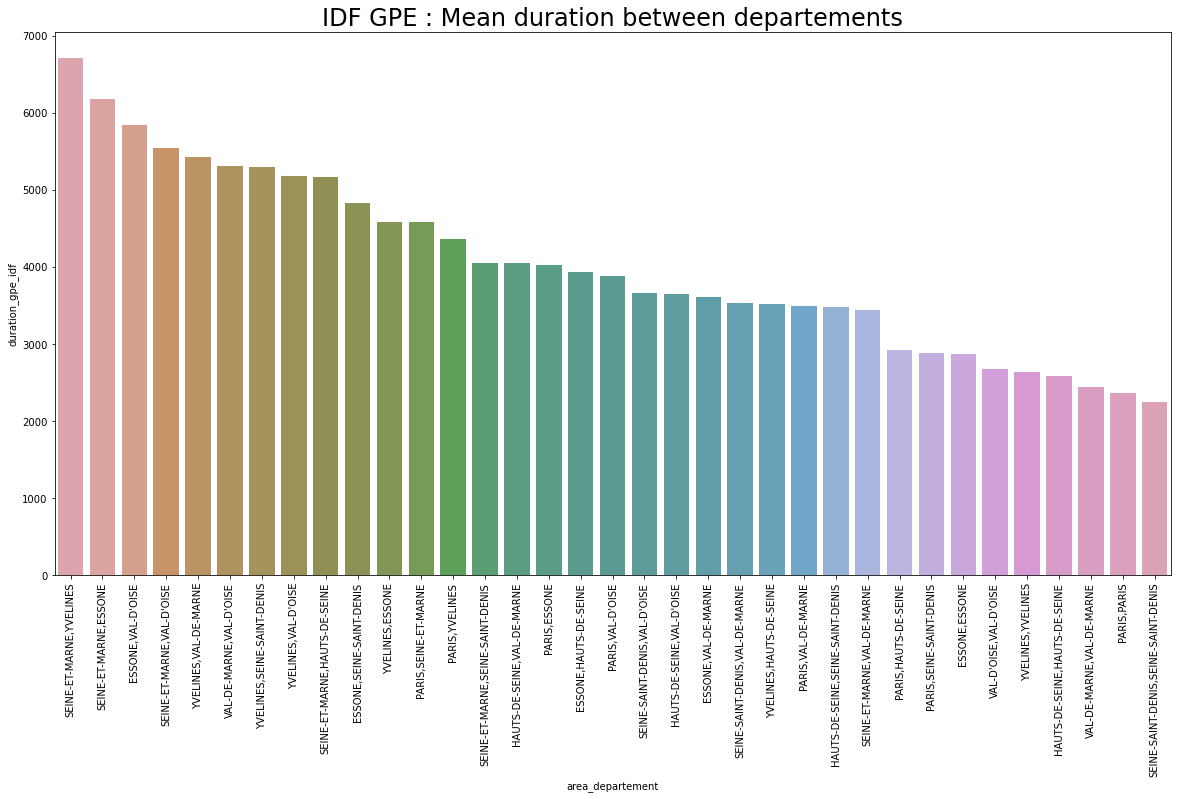

In [45]:
plot_mean_duration_between_departements(
    df_duration.loc[pd.isna(df_duration["duration_idf"]) == False].sort_values("duration_idf", ascending=False), 
    "IDF now : Mean duration between departements", 
    "duration_idf"
)

plot_mean_duration_between_departements(
    df_duration.loc[pd.isna(df_duration["duration_gpe_idf"]) == False].sort_values("duration_gpe_idf", ascending=False), 
    "IDF GPE : Mean duration between departements",
    "duration_gpe_idf"
)

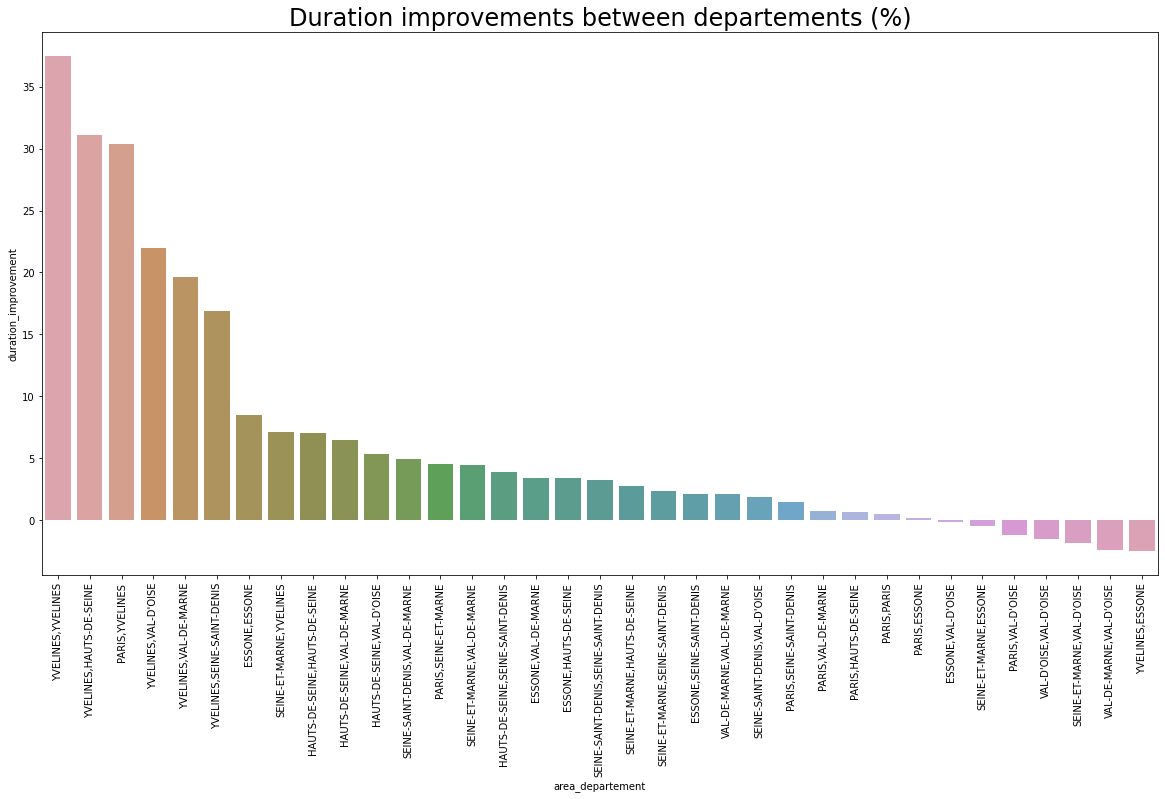

In [46]:
plot_mean_duration_between_departements(
    df_duration.loc[pd.isna(df_duration["duration_improvement"]) == False].sort_values("duration_improvement", ascending=False), 
    "Duration improvements between departements (%)",
    "duration_improvement"
)